In [1]:
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
last_date_forecast = 91

In [3]:
df_forecasts_blocks = pd.read_csv(os.path.join(
    'data', 'model', f'predictions_blocks_day_0_day_{last_date_forecast}.csv'),
     sep=';', index_col = 0, dtype=float, na_values=' ')
df_forecasts_blocks.index = df_forecasts_blocks.index.astype(int) 
print(f'Forecasts blocks 0 - {last_date_forecast} (shape {df_forecasts_blocks.shape})')
display(df_forecasts_blocks.head())
print('******************************************\n')

df_blocks = pd.read_csv(os.path.join('data', 'raw', 'product_blocks.csv'))
df_blocks_count = df_blocks.groupby('block_id').count().rename(columns={'product_id': 'nb_products_in_block'})
df_blocks = df_blocks_count.join(df_blocks.set_index('block_id')).reset_index()
df_blocks = df_blocks[['product_id', 'block_id', 'nb_products_in_block']]
print(f'Products by block denormalized (shape {df_blocks.shape})')
display(df_blocks.head())
print('******************************************\n')

nb_blocks_forecasts = df_forecasts_blocks.shape[0]
nb_blocks_true = df_blocks.nunique()['block_id']
print(f'There are {nb_blocks_forecasts} unique blocks in forecasts Vs {nb_blocks_true} in blocks table')

Forecasts blocks 0 - 91 (shape (2583, 92))


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X82,X83,X84,Y85,Y86,Y87,Y88,Y89,Y90,Y91
0,674.60,656.90,403.20,950.40,764.65,481.15,163.65,619.05,419.10,327.45,...,709.050,389.45,888.850,885.58,866.28,858.38,854.33,851.82,850.09,848.85
1,29.95,149.75,89.85,179.70,359.40,59.90,89.85,59.90,149.75,29.95,...,1316.600,1105.35,940.450,919.58,891.67,867.34,846.10,827.53,811.28,797.04
2,679.40,1228.90,789.25,1138.95,1258.90,1318.85,779.30,689.40,569.50,779.25,...,549.450,359.65,849.150,681.57,679.75,683.60,680.29,679.35,680.66,678.77
3,53.91,5.99,41.93,83.86,113.81,101.83,89.85,71.88,83.86,59.90,...,0.001,39.95,0.001,9.86,9.75,9.64,9.53,9.42,9.31,9.20
4,1267.90,1627.20,1008.25,998.20,1647.30,898.40,848.60,1108.10,688.90,808.50,...,2775.150,2831.25,2759.300,2597.75,2506.57,2423.58,2348.09,2279.35,2216.74,2159.70


******************************************

Products by block denormalized (shape (15238, 3))


,product_id,block_id,nb_products_in_block
0,612967398,0,7
1,296892108,0,7
2,139541214,0,7
3,963923934,0,7
4,938230141,0,7


******************************************

There are 2583 unique blocks in forecasts Vs 2776 in blocks table


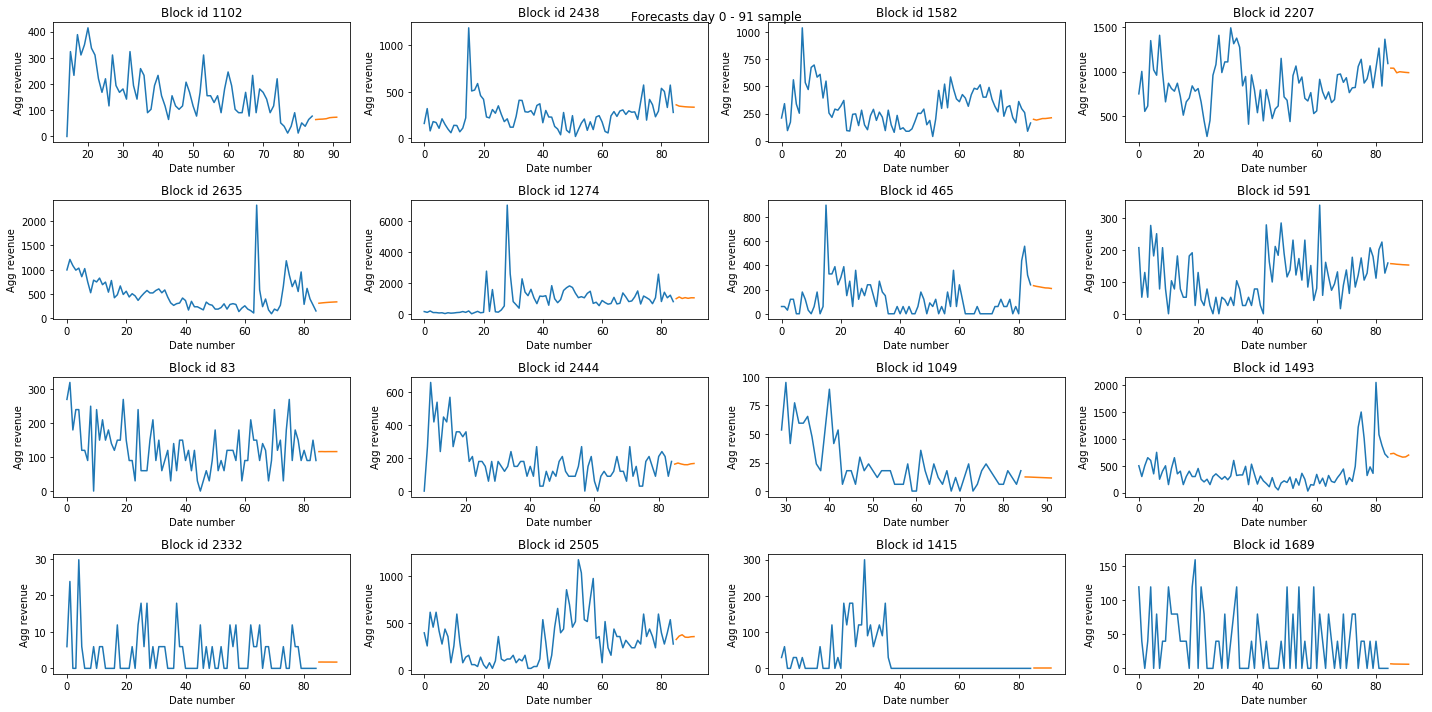

In [4]:
nrows = 4
ncols = 4

def plot_ts_and_forecast(series, ax):
    x = series.filter(regex=("X.*")).values.flatten()
    y = series.filter(regex=("Y.*")).values.flatten()
    sns.lineplot(x=range(len(x)), y=x, ax=ax)
    sns.lineplot(x=range(len(x), len(x) + len(y)), y=y, ax=ax)
    ax.set_title(f'Block id {series.name}')
    ax.set_ylabel('Agg revenue')
    ax.set_xlabel('Date number')

fig, ax = plt.subplots(nrows, ncols, figsize=(20, 10))
df = df_forecasts_blocks.sample(nrows * ncols)
for i in range(nrows):
    for j in range(ncols):
        index = (i * ncols) + j
        plot_ts_and_forecast(df.iloc[index], ax[i, j])
        
fig.suptitle(f'Forecasts day 0 - {last_date_forecast} sample')
plt.tight_layout()
plt.show()

In [5]:
df_forecasts_blocks_y = df_forecasts_blocks.filter(regex=("Y.*"))

In [6]:
ranking_blocks = df_forecasts_blocks_y.sum(axis=1).sort_values(ascending=False).to_frame('revenue').join(df_blocks_count)
print('Blocks ranking (expected)')
display(ranking_blocks.head())

Blocks ranking (expected)


,revenue,nb_products_in_block
2443,32071.64,6
812,31447.79,8
2128,28790.43,6
1580,22738.72,8
1750,22664.56,8


In [7]:
day_1_block_ids = None
day_1_prod_ids = None
expected_revenue_same_bet = 0
try:
    with open('day_1_blocks_bet.txt', 'r') as f:
        day_1_blocks_bet = set()
        for block_id in f.readlines():
            block_id = int(block_id.strip())
            day_1_blocks_bet.add(block_id)
        df_day_1_blocks_bet = ranking_blocks.loc[day_1_blocks_bet].sort_values('revenue', ascending=False)
        day_1_block_ids = set(df_day_1_blocks_bet.index)
        day_1_prod_ids = set(df_blocks[df_blocks['block_id'].isin(day_1_block_ids)]['product_id'])
    print('First day bet (blocks):', day_1_block_ids)
    print(f'Block ids ({len(day_1_block_ids)}):', day_1_block_ids)
    print(f'Product ids ({len(day_1_prod_ids)}):', day_1_prod_ids)
    display(df_day_1_blocks_bet)
    expected_revenue_same_bet = sum(df_day_1_blocks_bet['revenue'])
    print('Expected revenue with same bet:', expected_revenue_same_bet)
except FileNotFoundError:
    print('No first day bets')

First day bet (blocks): {388, 358, 487, 553, 812, 2128, 2037, 2359}
Block ids (8): {388, 358, 487, 553, 812, 2128, 2037, 2359}
Product ids (50): {48715520, 6092033, 746821379, 850758408, 260607241, 546145801, 400217100, 549428749, 645173005, 363508111, 209499788, 547602324, 106554518, 364167448, 675564699, 679568934, 861287590, 123972907, 289600941, 753557551, 146820915, 99663284, 582230835, 843348404, 286686535, 838377545, 279854545, 360962129, 87049042, 986936152, 19599326, 795275487, 37119458, 180855907, 506319972, 765361509, 216812261, 898725227, 822543851, 183511277, 568044141, 994783854, 858136433, 100290932, 210758773, 605492598, 848832888, 275025659, 890876414, 897939967}


,revenue,nb_products_in_block
812,31447.79,8
2128,28790.43,6
2037,22374.44,4
388,21025.98,8
487,16254.62,8
553,15085.70,8
358,14199.12,7
2359,7450.57,1


Expected revenue with same bet: 156628.65


In [8]:
removed_blocks = set([487, 553, 2359])

removed_prods = set(df_blocks[df_blocks['block_id'].isin(removed_blocks)]['product_id'])
df_removed = df_day_1_blocks_bet.loc[removed_blocks]
nb_prods_removed = sum(df_removed['nb_products_in_block'])
assert len(removed_prods) == nb_prods_removed
revenue_drop = sum(df_removed['revenue'])
print(f'Removing blocks {removed_blocks} for a total of {nb_prods_removed} products and {revenue_drop} revenue drop')
df_day_1_blocks_bet_r = df_day_1_blocks_bet.drop([487, 388], axis=0)
display(df_day_1_blocks_bet_r)

Removing blocks {553, 2359, 487} for a total of 17 products and 38790.89 revenue drop


,revenue,nb_products_in_block
812,31447.79,8
2128,28790.43,6
2037,22374.44,4
553,15085.70,8
358,14199.12,7
2359,7450.57,1


In [9]:
min_revenue_to_accept = ranking_blocks.iloc[60].revenue
print('Min revenue from block to accept', min_revenue_to_accept)

day_n_block_ids = set() if not day_1_block_ids else (day_1_block_ids - removed_blocks)
day_n_prod_ids = set() if not day_1_prod_ids else (day_1_prod_ids - removed_prods)

print('Starting bet', day_n_block_ids)

revenue_balance = -revenue_drop

for block_id, row in ranking_blocks.sort_values(by=['nb_products_in_block', 'revenue'], ascending=[True, False]).iterrows():
    if len(day_n_prod_ids) == 50:
        print('Done!')
        break
    revenue, nb_products = row.values
    if revenue > min_revenue_to_accept:
        prods_to_add = set(df_blocks[df_blocks['block_id'] == block_id]['product_id'])
        nb_prods_add = len(prods_to_add)
        if block_id in day_n_block_ids:
            print(f'[✗] Block {block_id:<4} already added')
            continue
        if (len(prods_to_add) + len(day_n_prod_ids) > 50):
            print(f'[✗] Cannot add {block_id:<4} with {nb_prods_add:<1} products. Sum > 50')
            difference = 50 - len(day_n_prod_ids)
            print(f'Searching best block with {difference} products')
            for block_id, row in ranking_blocks[ranking_blocks['nb_products_in_block'] == difference].sort_values(
                'revenue', ascending=False).iterrows():
                if block_id in day_n_block_ids:
                    print(f'[✗] Block {block_id:<4} already added')
                    continue
                print(f'[✓] Adding {block_id:<4} with {difference:<1} products (+{revenue:<9.3f} revenue)')
                revenue_balance += revenue
                day_n_block_ids.add(block_id)
                prods_to_add = set(df_blocks[df_blocks['block_id'] == block_id]['product_id'])
                day_n_prod_ids = day_n_prod_ids.union(prods_to_add)
                break
            if len(day_n_prod_ids) < 50:
                print('[✗] Could not find any!')
            break
        print(f'[✓] Adding {block_id:<4} with {nb_prods_add:<1} products (+{revenue:<9.3f} revenue)')
        revenue_balance += revenue
        day_n_block_ids.add(block_id)
        day_n_prod_ids = day_n_prod_ids.union(prods_to_add)
        
if len(day_n_prod_ids) == 50:
    print('********************** NEW BETS **********************')
    print(f'Old block ids ({len(day_1_block_ids)}):', sorted(day_1_block_ids))
    print(f'New block ids ({len(day_n_block_ids)}):', sorted(day_n_block_ids))
    print(f'New product ids ({len(day_n_prod_ids)}):', day_n_prod_ids)
    new_revenue = sum(ranking_blocks.loc[day_n_block_ids].revenue)
    print(f'New revenue {new_revenue:<9.3f} ({revenue_balance:<9.3f} compared with last bet)')
    print('********************** Checking validity **********************')
    print(f'Number of changed items = {len(day_n_prod_ids.difference(day_1_prod_ids))}')
    print(f'Number of changed blocks = {len(day_n_block_ids.difference(day_1_block_ids))}')
    df_blocks[df_blocks['block_id'].isin(day_n_prod_ids)]

Min revenue from block to accept 9493.69
Starting bet {388, 358, 812, 2128, 2037}
[✓] Adding 96   with 1 products (+12862.760 revenue)
[✓] Adding 1850 with 1 products (+11026.290 revenue)
[✓] Adding 2306 with 3 products (+12169.960 revenue)
[✓] Adding 943  with 3 products (+10387.400 revenue)
[✗] Block 2037 already added
[✓] Adding 831  with 4 products (+13600.010 revenue)
[✓] Adding 2254 with 4 products (+9742.200  revenue)
[✗] Cannot add 1412 with 5 products. Sum > 50
Searching best block with 1 products
[✗] Block 96   already added
[✗] Block 1850 already added
[✓] Adding 2359 with 1 products (+17860.540 revenue)
********************** NEW BETS **********************
Old block ids (8): [358, 388, 487, 553, 812, 2037, 2128, 2359]
New block ids (12): [96, 358, 388, 812, 831, 943, 1850, 2037, 2128, 2254, 2306, 2359]
New product ids (50): {6092033, 651483649, 746821379, 647695493, 546145801, 209499788, 549428749, 143142291, 106554518, 364167448, 675564699, 679568934, 861287590, 859484199

In [10]:
def write_iterable(iterable, filepath):
    with open(filepath, 'w') as f:
        for line in iterable:
            print(line, file=f)

In [11]:
write_iterable(sorted(day_n_block_ids), 'day_3_blocks_bet.txt')

In [12]:
for filepath in glob.glob('day_[1-3]_blocks_bet.txt'):
    print(filepath)
    with open(filepath, 'r') as f:
        print(sorted(list(map(int, f.readlines()))))

day_1_blocks_bet.txt
[358, 388, 487, 553, 812, 2037, 2128, 2359]
day_2_blocks_bet.txt
[96, 118, 358, 388, 393, 805, 812, 1850, 2037, 2128, 2306, 2335, 2359]
day_3_blocks_bet.txt
[96, 358, 388, 812, 831, 943, 1850, 2037, 2128, 2254, 2306, 2359]
